# Biblioteka PyTorch

PyTorch jest darmową i otwartą biblioteką Python używaną głównie do szerokopojętego uczenia maszynowego, np. wizji komputerowej czy przetwarzania języka naturalnego. Stworzona w 2016r. przez badawczy oddział Facebooka na podstawie biblioteki Torch. W ostatnich latach zyskuję coraz większą część rynku, lecz ze względu na wielkość community i promowanie Google wciąż ustępuje Tensorflow. https://trends.google.com/trends/explore?date=today%205-y&q=%2Fg%2F11bwp1s2k3,%2Fg%2F11gd3905v1

W skrócie przedstawię zalety PyTorcha, które mogą skłonić nowych użytkowników:
* Prostota i filozofia Pythona. Korzystanie z Tensorflow przypomina naukę nowego języka,
* Łatwe debbugowanie architektury i możliwość obserwacji macierzy wag w sieci,
* Integracja z numpy, np metody jak: tensor.numpy i from_numpy, które przekształcają tensor na tablicę numpy i na odwrót,
* Dynamiczne budowanie architektury sieci, bardzo przydatne przy prototypowaniu,
*Subiektywna obserwacja: Pytorch po prostu działa. W TF wielokrotnie miałem problemy z niedziałającymi funkcjami w różnych wersjach, z problemem z wczytywaniem danych czy publikacją modelu. PyTorchu wiele upraszcza, np trening przy pomocy GPU można wykonać używając prstej komendy:
```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
```

Do przygotowania notebooka użyiśmy Google Colab, więc nie jest konieczne lokalne tworzenie środowiska wraz ze wszystkimi bibliotekami. Nie tłumaczymy całej teorii stojącej za budowaniem i treningiem sieci, gdyż to nie jest temat tego projektu. Ze względu na czas pominiemy wiele ważnych aspektów. Celem jest  wysokooziomowe zrozumienie biblioteki. Skupimy się na rozwiązaniach niedostępnych w innych bibliotekach oraz pokażemy przykład wytrenowania modelu.


## I Podstawy

### Macierz/Tensor

In [ ]:
from __future__ import print_function
import torch

x = torch.rand(5, 3) #losowa
y = torch.zeros(5, 3, dtype=torch.long) #wypełniona zerami
z = torch.tensor([9, 3]) # z zadanymi wartościami

print(x)
print(y)
print(z)

tensor([[0.1063, 0.6270, 0.4167],
        [0.0808, 0.8965, 0.7247],
        [0.8221, 0.3734, 0.8642],
        [0.4763, 0.7259, 0.7365],
        [0.3960, 0.3071, 0.9580]])
tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])
tensor([9, 3])


#### PyTorch Tensor <=> NumPy Array

Tensor PyTorcha jest koncepcyjnie identyczny z macierzą numpy: tensor jest macierzą n-wymiarową.
W przeciwieństwie do numpy, tensory mogą wykorzystywać GPU do przyspieszenia obliczeń numerycznych.

Tensor => NumPy

In [ ]:
a = torch.ones(5)
print(a)

tensor([1., 1., 1., 1., 1.])


In [ ]:
b = a.numpy()
print(b)

[1. 1. 1. 1. 1.]


Tensor <= NumPy

In [ ]:
import numpy as np

a = np.ones(5)
print(a)

[1. 1. 1. 1. 1.]


In [ ]:
b = torch.from_numpy(a)
print(b)

tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


### Autograd (Automatic differentiation)

Jest to zestaw technik do numerycznego obliczenia pochodnej funkcji. Dla zapoznania się z tematem odsyłam do: https://en.wikipedia.org/wiki/Automatic_differentiation.
W naszym przypadku jest to nazwa pakietu, którego centralną klasą jest Tensor. Kolejną klasą jest Function. Tensor i Function są ze sobą połączone i tworzą acykliczny graf, który koduje pełną historię obliczeń. Każdy tensor ma atrybut .grad_fn, który odwołuje się do funkcji, która utworzyła ten Tensor. Pozwala to śledzić historię i pomaga w kontroli swoich obliczeń.

### Sieci neuronowe

PyTorch posiada ogromny pakiet nn, w którym jest większość modułów wykorzystywanych do budowy sieci. Zawiera różne typy warstw, funkcji straty oraz technik optymalizacyjnych. Do dalszego zapoznania się odsyłam do dokumentacji: https://pytorch.org/docs/stable/nn.html#
![alt Przykładowa sieć](https://www.extremetech.com/wp-content/uploads/2015/07/NeuralNetwork.png)


Przykład prostej, dwuwarstwowej sieci:

In [ ]:
N = 64 #wielkość paczki (batch size)
D_in = 1000 #wymiar wejścia (input dimension)
H = 100  #wymiar ukryty (hidden dimension)
D_out = 10 #wymiar wyjściowy (output dimension)

# Losowe tensory na wejściu i wyjściu
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# 2 warstwy liniowe + ReLu jako funkcja aktywacji + MSE jako funkcja kosztu
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')


#Używamy Adam jako algorytmu optymalizacyjnego z podaną szybkością uczenia 
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    y_pred = model(x)

    # Wypisujemy koszt
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    #Zerujemy gradienty
    optimizer.zero_grad()

    #Obliczamy gradient
    loss.backward()

    #Aktualizujemy
    optimizer.step()

99 38.35531234741211
199 0.2860768139362335
299 0.0007231177296489477
399 4.6238210416049697e-07
499 1.4571507889193924e-10


## II Zastosowanie PyTorcha do sieci StyleGAN


StyleGan to stworzona w 2018 roku wersja architektury GAN (generative adversarial network) służąca do przenoszenia 'stylu' między obrazami. Do budowy sieci wykorzystujemy transfer learning już przetrenowanej sieci vgg-16.

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [113]:
!wget -O style.jpg "https://render.fineartamerica.com/images/rendered/default/print/8/5.5/break/images/artworkimages/medium/1/umegawa-in-sagami-province-one-of-thirty-six-views-of-mount-fuji-hokusai.jpg"
!wget -O mountain.jpg "https://cdn.britannica.com/47/80547-050-8B316D38/Field-green-tea-Mount-Fuji-Shizuoka-prefecture.jpg"

--2020-05-24 21:37:25--  https://render.fineartamerica.com/images/rendered/default/print/8/5.5/break/images/artworkimages/medium/1/umegawa-in-sagami-province-one-of-thirty-six-views-of-mount-fuji-hokusai.jpg
Resolving render.fineartamerica.com (render.fineartamerica.com)... 54.230.161.75, 54.230.161.10, 54.230.161.31, ...
Connecting to render.fineartamerica.com (render.fineartamerica.com)|54.230.161.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95569 (93K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>]  93.33K  --.-KB/s    in 0.05s   

2020-05-24 21:37:25 (1.82 MB/s) - ‘style.jpg’ saved [95569/95569]

--2020-05-24 21:37:26--  https://cdn.britannica.com/47/80547-050-8B316D38/Field-green-tea-Mount-Fuji-Shizuoka-prefecture.jpg
Resolving cdn.britannica.com (cdn.britannica.com)... 13.35.112.115, 13.35.112.49, 13.35.112.123, ...
Connecting to cdn.britannica.com (cdn.britannica.com)|13.35.112.115|:443... connected.
HTTP reque

In [115]:
!ls

aa.jpg	b.jpg		 Draw-Anime-Hair.1  style.jpg
aa.png	b.png		 mountain.jpg	    xWXDQtYvRyop4d1e9
a.jpg	Draw-Anime-Hair  sample_data


In [ ]:
imsize = 512 if torch.cuda.is_available() else 128 

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = image.resize((1024,1024), Image.ANTIALIAS)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("/content/style.jpg")
content_img = image_loader("/content/mountain.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

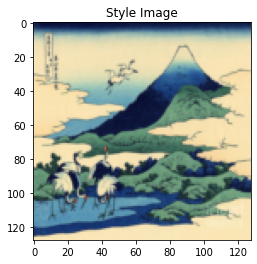

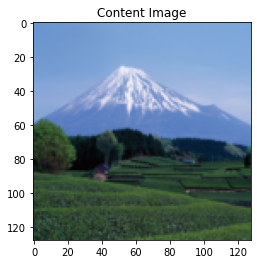

In [118]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone() 
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
# Importujemy przetrenowany model vgg-16
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
#input_img = content_img.clone()
#plt.figure()
#imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 546.844788 Content Loss: 29.313084

run [100]:
Style Loss : 193.892883 Content Loss: 31.928564

run [150]:
Style Loss : 101.090332 Content Loss: 32.585785

run [200]:
Style Loss : 65.356720 Content Loss: 32.808075

run [250]:
Style Loss : 44.859283 Content Loss: 32.924187

run [300]:
Style Loss : 33.664764 Content Loss: 32.742771



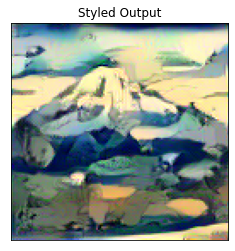

In [128]:
styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled_output, title='Styled Output')

plt.show()